# Contraceptive Use in Indonesia: 1987 Study #

## Source: UCI Machine Learning Repository ##
### URL: [WebLink](https://archive.ics.uci.edu/ml/datasets/Contraceptive+Method+Choice)


Source:

** Origin: **
- This dataset is a subset of the 1987 National Indonesia Contraceptive Prevalence Survey 

** Creator and Donor: **
- [Tjen-Sien Lim](limt@stat.wisc.edu) 

** Relevant Papers:**
- [Lim, T.-S., Loh, W.-Y. & Shih, Y.-S. (1999). A Comparison of Prediction Accuracy, Complexity, and Training Time of Thirty-three Old and New Classification Algorithms. Machine Learning](http://www.stat.wisc.edu/~loh/treeprogs/guide/mach1317.pdf)

In [1]:
data = 'https://archive.ics.uci.edu/ml/machine-learning-databases/cmc/cmc.data'

import pandas as pd
import numpy as np
import requests
import re

import matplotlib.pyplot as plt
import seaborn as sb
import bokeh as bk
from bokeh.models import ColumnDataSource, HoverTool, CategoricalColorMapper, Slider
from bokeh.io import curdoc, show, output_notebook, push_notebook, output_file
from bokeh.layouts import widgetbox, column, row, gridplot
from bokeh.plotting import figure

%matplotlib inline
plt.style.use('bmh')

pink_green = 'PiYG'
paired_colors = 'Paired'


##for CatColorMapper, 
''' 
CatColMap = CategoricalColorMapper(factors =[], palette = [])
Hover = HoverTool(tooltips=[('string label','@column_name')])

plot.add_tools(Hover)
plot.circle(x,y,source=source,color={'field':[column_name],'transform':[CatColMap]})'''

##for gridplot,
'''
layout = gridplot(list of rows)
gridplot shares the toolbar for all plots
'''

##for callbacks,
'''
def callback(attr,old,new):
    [insert Slider function]
    
slider.on_change('value',callback)
'''

##for bokeh server,
'''
curdoc().add_root(layout)

in the shell:

bokeh serve --show myapplication.py
'''

'\ncurdoc().add_root(layout)\n\nin the shell:\n\nbokeh serve --show myapplication.py\n'

In [2]:
url = requests.get(data)

In [89]:
url.text[:100]

'24,2,3,3,1,1,2,3,0,1\n45,1,3,10,1,1,3,4,0,1\n43,2,3,7,1,1,3,4,0,1\n42,3,2,9,1,1,3,3,0,1\n36,3,3,8,1,1,3,'

In [4]:
rows = url.text.split(sep='\n')

In [96]:
rows[0]

'24,2,3,3,1,1,2,3,0,1'

In [32]:
rows_lists = [[l] for l in rows]

In [33]:
pattern = '\d+'

In [55]:
rows_ints = [re.findall(pattern,l) for l in rows]
#rows_ints = [list(map(int,re.findall(pattern,l))) for l in rows]

## Function thought: add option to import data as category or int

In [56]:
rows_ints[-1]

[]

In [57]:
'''1. Wife's age                     (numerical)
   2. Wife's education               (categorical)      1=low, 2, 3, 4=high
   3. Husband's education            (categorical)      1=low, 2, 3, 4=high
   4. Number of children ever born   (numerical)
   5. Wife's religion                (binary)           0=Non-Islam, 1=Islam
   6. Wife's now working?            (binary)           0=Yes, 1=No
   7. Husband's occupation           (categorical)      1, 2, 3, 4
   8. Standard-of-living index       (categorical)      1=low, 2, 3, 4=high
   9. Media exposure                 (binary)           0=Good, 1=Not good
   10. Contraceptive method used     (class attribute)  1=No-use 
                                                        2=Long-term
                                                        3=Short-term'''


columns = ['wife_age','wife_edu','husb_edu','num_child','wife_islam','wife_unemployed','husb_occupation','life_std','bad_media','contra_type']

In [58]:
df = pd.DataFrame.from_records(rows_ints[:-1],columns=columns)

In [59]:
df.tail()

,wife_age,wife_edu,husb_edu,num_child,wife_islam,wife_unemployed,husb_occupation,life_std,bad_media,contra_type
1468,33,4,4,2,1,0,2,4,0,3
1469,33,4,4,3,1,1,1,4,0,3
1470,39,3,3,8,1,0,1,4,0,3
1471,33,3,3,4,1,0,2,2,0,3
1472,17,3,3,1,1,1,2,4,0,3


In [60]:
df['wife_age'] = df['wife_age'].astype('int64')

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1473 entries, 0 to 1472
Data columns (total 10 columns):
wife_age           1473 non-null int64
wife_edu           1473 non-null object
husb_edu           1473 non-null object
num_child          1473 non-null object
wife_islam         1473 non-null object
wife_unemployed    1473 non-null object
husb_occupation    1473 non-null object
life_std           1473 non-null object
bad_media          1473 non-null object
contra_type        1473 non-null object
dtypes: int64(1), object(9)
memory usage: 115.2+ KB


In [64]:
age_range = df.wife_age.max() - df.wife_age.min()

[]

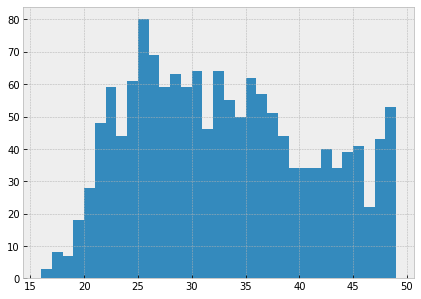

In [68]:
df.wife_age.hist(bins=age_range,figsize=(7,5))
plt.plot()

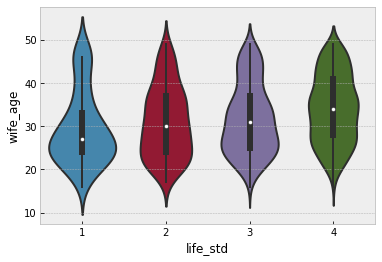

In [103]:
sb.violinplot(x='life_std',y='wife_age',data=df)